In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import json

from gcpUtils.auth import getCredentials
from gcpUtils.bigQuery import pandasToBq, tableToPandas
from gcpUtils.google_storage_manager import *

plt.rcParams['font.family'] = 'sans-serif'

In [230]:
with open("dados/filiais_inferior_30.json", 'r', encoding='utf-8') as f:
    dados_filiais = json.load(f)

lista_de_filiais = [item['FILIAL'] for item in dados_filiais]
filiais_corretas = ", ".join([f"'{f}'" for f in lista_de_filiais])


In [231]:
cred = getCredentials("../bd/planejamento-animale-292719-296d49ccdea6.json")

query = f"""
WITH rupturas AS (
    SELECT
        FILIAL,
        SKU,
        DATA,
        CONT_RUPTURA,
        LEADTIME,
        CASE 
            WHEN CONT_RUPTURA = 1
                AND LAG(CONT_RUPTURA, 1, 0) OVER (
                    PARTITION BY FILIAL, SKU ORDER BY DATA
                ) = 0
            THEN 1 ELSE 0
        END AS inicio_ruptura
    FROM `planejamento-animale-292719.checklists_rollout.ANIMALE_checklist`
    WHERE DATA > '2025-01-15' 
      AND DATA < '2025-10-11'
      AND FILIAL IN ({filiais_corretas})
),
grupos AS (
    SELECT
        FILIAL,
        SKU,
        DATA,
        CONT_RUPTURA,
        LEADTIME,
        SUM(inicio_ruptura) OVER (
            PARTITION BY FILIAL, SKU ORDER BY DATA ROWS UNBOUNDED PRECEDING
        ) AS RUPTURA_ID
    FROM rupturas
    WHERE CONT_RUPTURA = 1
),
resumo AS (
    SELECT
        FILIAL,
        SKU,
        RUPTURA_ID,
        MIN(CAST(DATA AS DATE)) AS inicio_ruptura,
        MAX(CAST(DATA AS DATE)) AS fim_ruptura,
        DATE_DIFF(
        MAX(CAST(DATA AS DATE)), MIN(CAST(DATA AS DATE)), DAY
        ) + 1 AS DIAS_RUPTURA,
        MAX(LEADTIME) AS LEADTIME
    FROM grupos
    GROUP BY FILIAL, SKU, RUPTURA_ID
)
SELECT *
FROM resumo
ORDER BY FILIAL, SKU, RUPTURA_ID;
"""


In [232]:
dados = tableToPandas(query, 'planejamento-animale-292719', cred)
dados.columns = dados.columns.str.upper()

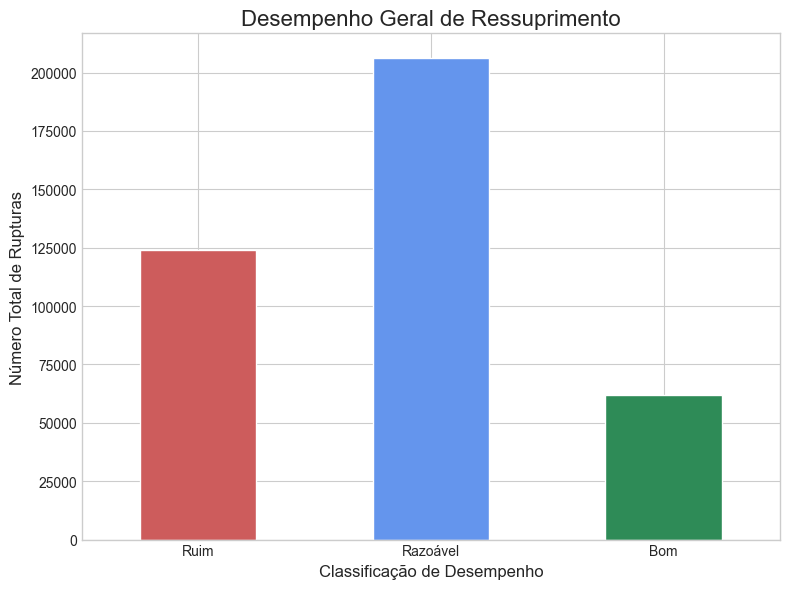

In [233]:
#CASO 1 - COM DIAS SOMANDO NO DENOMINADOR

epsilon = 1e-9
alpha = 0.5 

dados['IET'] = (dados['LEADTIME'] - dados['DIAS_RUPTURA']) / \
               (dados['LEADTIME'] + dados['DIAS_RUPTURA'] + epsilon)

conditions = [
    dados['IET'] < -alpha,  # Ruim
    dados['IET'] > alpha,   # Bom
]
choices = ['Ruim', 'Bom']
dados['CLASSE'] = np.select(conditions, choices, default='Razoável')

contagem_classe = dados['CLASSE'].value_counts() # Contagem total de rupturas em cada uma das três classes
ordem_classes = ['Ruim', 'Razoável', 'Bom']
contagem_classe = contagem_classe.reindex(ordem_classes, fill_value=0) # Garante que a ordem das barras no gráfico será sempre lógica

# gráfico

cores = {
    'Ruim': 'indianred',
    'Razoável': 'cornflowerblue',
    'Bom': 'seagreen'
}

plt.figure(figsize=(8, 6))

ax = contagem_classe.plot(
    kind='bar',
    color=[cores.get(c) for c in ordem_classes]
)

plt.title('Desempenho Geral de Ressuprimento', fontsize=16)
plt.ylabel('Número Total de Rupturas', fontsize=12)
plt.xlabel('Classificação de Desempenho', fontsize=12)
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()


C:\Users\gabri\AppData\Local\Temp\ipykernel_49948\3699417290.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


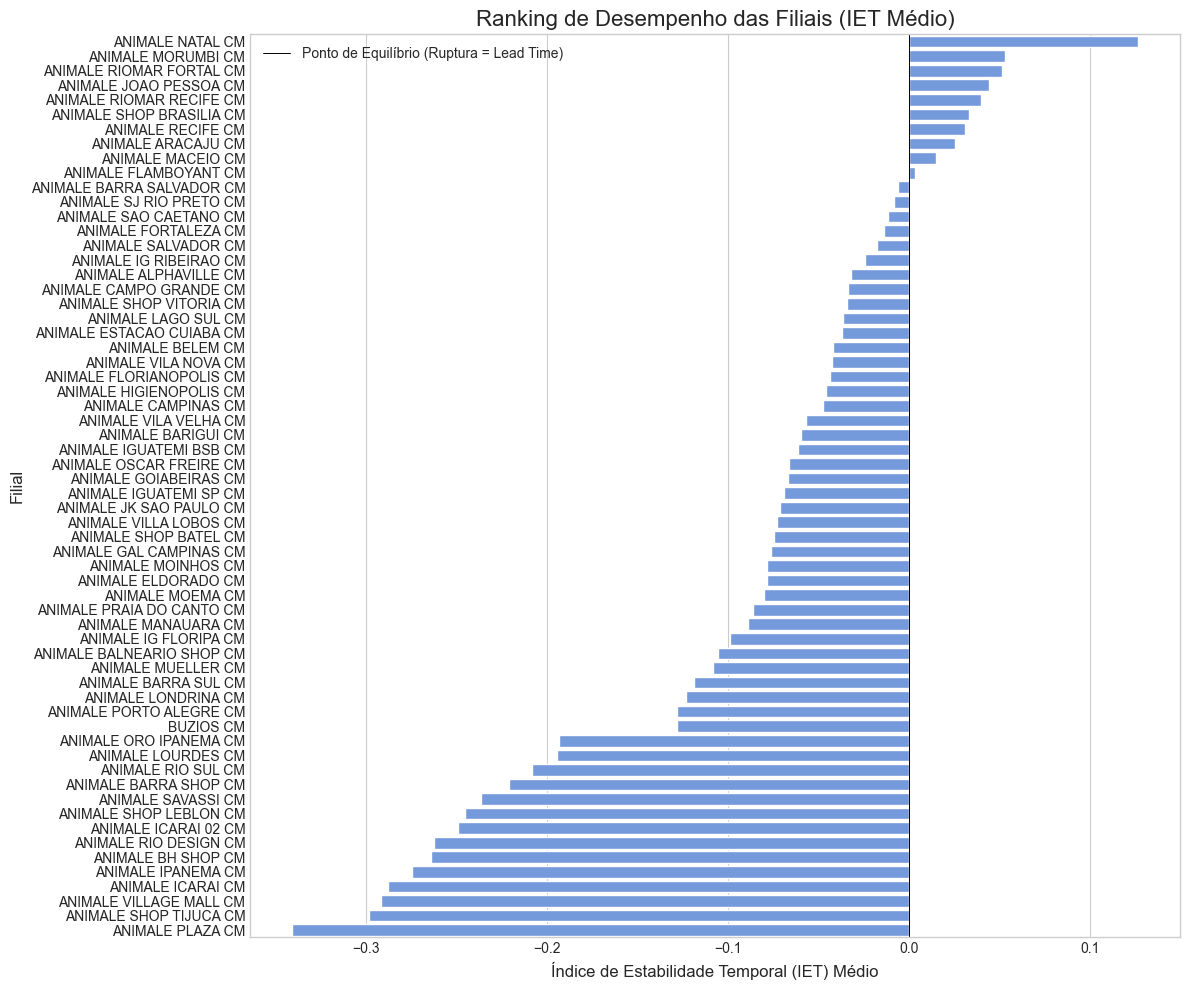

In [234]:
alpha = 0.5

desempenho_filiais = dados.groupby('FILIAL')['IET'].agg(IET_MEDIO='mean').reset_index() # Agrupar por filial e calcular o IET médio
desempenho_filiais = desempenho_filiais.sort_values('IET_MEDIO', ascending=False) # Ordenar as filiais pela performance, da melhor para a pior

cores_barras = []
for iet in desempenho_filiais['IET_MEDIO']:
    if iet > alpha:
        cores_barras.append('seagreen')    # Cor para 'Bom'
    elif iet < -alpha:
        cores_barras.append('indianred')     # Cor para 'Ruim'
    else:
        cores_barras.append('cornflowerblue') # Cor para 'Razoável'

plt.figure(figsize=(12, 10))

barplot = sns.barplot(
    x='IET_MEDIO',
    y='FILIAL',
    data=desempenho_filiais,
    palette=cores_barras,  # Usa a lista de cores que criamos
    orient='h'
)

#plt.axvline(x=alpha, color='darkgreen', linestyle='--', label=f'Limite Bom (IET > {alpha})')
#plt.axvline(x=-alpha, color='darkred', linestyle='--', label=f'Limite Ruim (IET < {-alpha})')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.7, label='Ponto de Equilíbrio (Ruptura = Lead Time)')
plt.title('Ranking de Desempenho das Filiais (IET Médio)', fontsize=16)
plt.xlabel('Índice de Estabilidade Temporal (IET) Médio', fontsize=12)
plt.ylabel('Filial', fontsize=12)
plt.legend()
plt.tight_layout() 
plt.show()



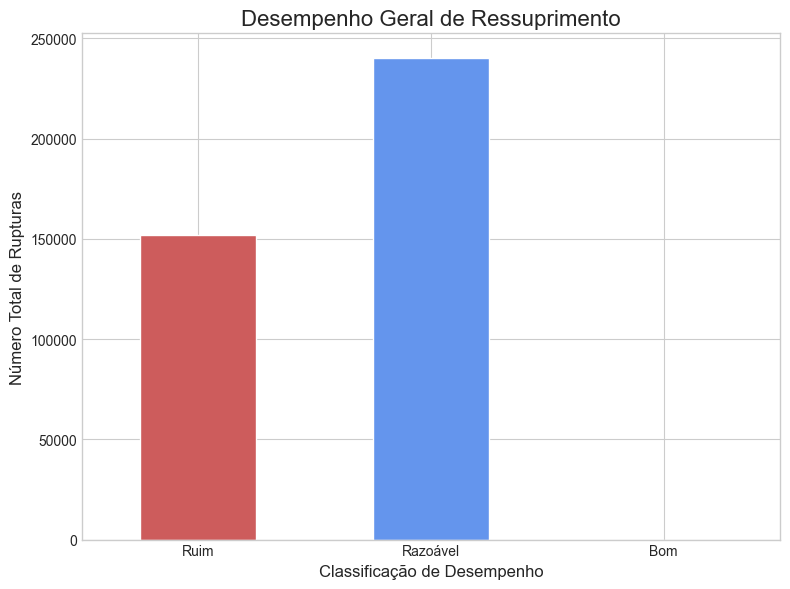

In [235]:
#CASO 2 - SEM DIAS SOMANDO NO DENOMINADOR

epsilon = 1e-9
alpha = 1 

dados['IET'] = (dados['LEADTIME'] - dados['DIAS_RUPTURA']) / \
               (dados['LEADTIME'] + epsilon)

conditions = [
    dados['IET'] < -alpha,  # Ruim
    dados['IET'] > alpha,   # Bom
]

choices = ['Ruim', 'Bom']
dados['CLASSE'] = np.select(conditions, choices, default='Razoável')

contagem_classe = dados['CLASSE'].value_counts() # Contagem total de rupturas em cada uma das três classes
ordem_classes = ['Ruim', 'Razoável', 'Bom']
contagem_classe = contagem_classe.reindex(ordem_classes, fill_value=0) # Garante que a ordem das barras no gráfico será sempre lógica

# gráfico
cores = {
    'Ruim': 'indianred',
    'Razoável': 'cornflowerblue',
    'Bom': 'seagreen'
}

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

ax = contagem_classe.plot(
    kind='bar',
    color=[cores.get(c) for c in ordem_classes]
)

plt.title('Desempenho Geral de Ressuprimento', fontsize=16)
plt.ylabel('Número Total de Rupturas', fontsize=12)
plt.xlabel('Classificação de Desempenho', fontsize=12)
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()


C:\Users\gabri\AppData\Local\Temp\ipykernel_49948\3699417290.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


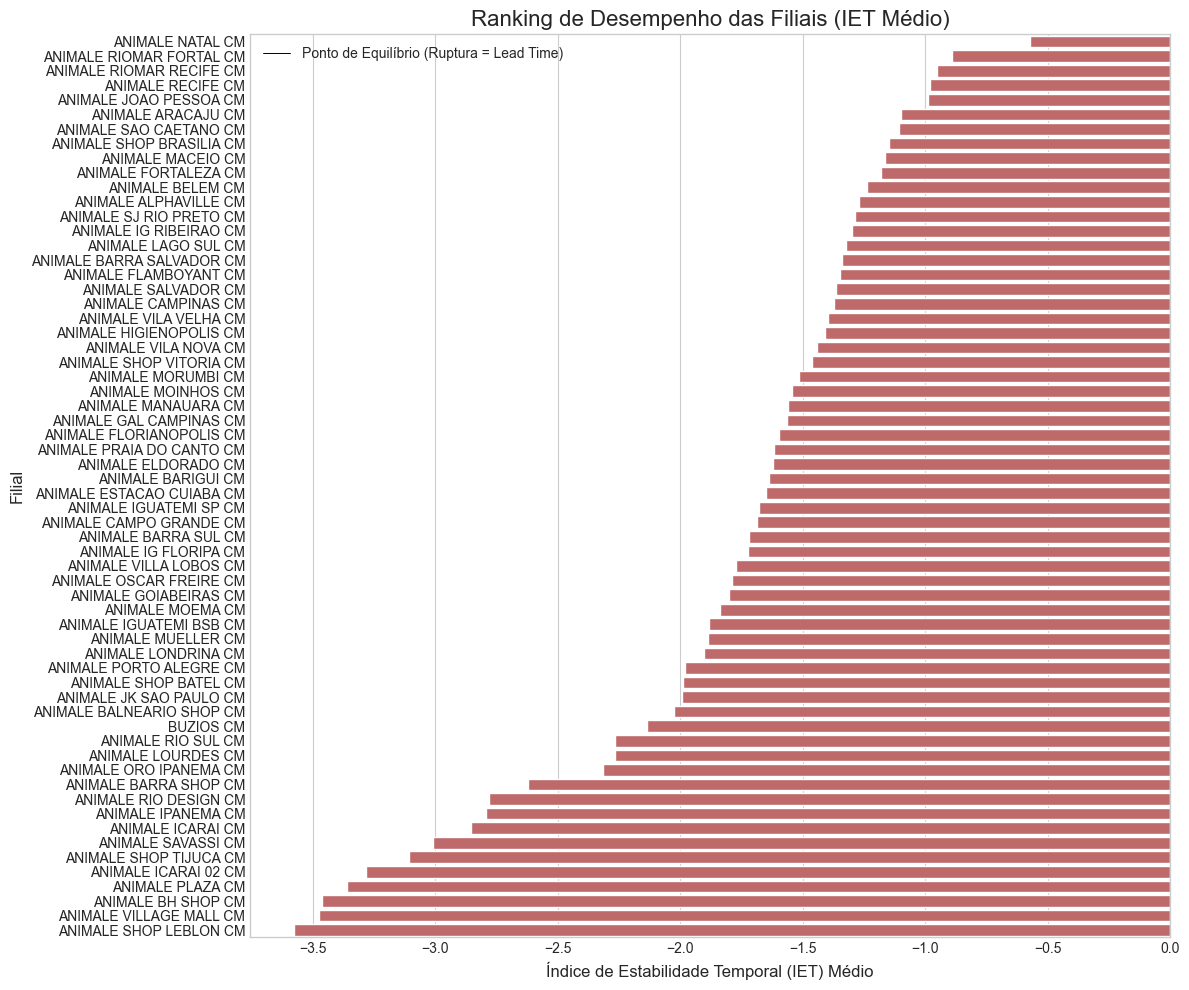

In [239]:
alpha = 0.5

desempenho_filiais = dados.groupby('FILIAL')['IET'].agg(IET_MEDIO='mean').reset_index() # Agrupar por filial e calcular o IET médio
desempenho_filiais = desempenho_filiais.sort_values('IET_MEDIO', ascending=False) # Ordenar as filiais pela performance, da melhor para a pior

cores_barras = []
for iet in desempenho_filiais['IET_MEDIO']:
    if iet > alpha:
        cores_barras.append('seagreen')    # Cor para 'Bom'
    elif iet < -alpha:
        cores_barras.append('indianred')     # Cor para 'Ruim'
    else:
        cores_barras.append('cornflowerblue') # Cor para 'Razoável'

plt.figure(figsize=(12, 10))

barplot = sns.barplot(
    x='IET_MEDIO',
    y='FILIAL',
    data=desempenho_filiais,
    palette=cores_barras,  # Usa a lista de cores que criamos
    orient='h'
)

#plt.axvline(x=alpha, color='darkgreen', linestyle='--', label=f'Limite Bom (IET > {alpha})')
#plt.axvline(x=-alpha, color='darkred', linestyle='--', label=f'Limite Ruim (IET < {-alpha})')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.7, label='Ponto de Equilíbrio (Ruptura = Lead Time)')
plt.title('Ranking de Desempenho das Filiais (IET Médio)', fontsize=16)
plt.xlabel('Índice de Estabilidade Temporal (IET) Médio', fontsize=12)
plt.ylabel('Filial', fontsize=12)
plt.legend()
plt.tight_layout() 
plt.show()

